In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('Tweets.csv')
df=df[:10000]

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [39]:
df.shape()

TypeError: 'tuple' object is not callable

In [11]:
# Cleaning the texts
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, 10000):
    review = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
corpus=pd.DataFrame(corpus, columns=['Reviews']) 
corpus.head()

,Reviews
0,virginamerica dhepburn said
1,virginamerica plu ad commerci experi tacki
2,virginamerica today must mean need take anoth ...
3,virginamerica realli aggress blast obnoxi ente...
4,virginamerica realli big bad thing


In [13]:
result=corpus.join(df[['airline_sentiment']])
result.head()

,Reviews,airline_sentiment
0,virginamerica dhepburn said,neutral
1,virginamerica plu ad commerci experi tacki,positive
2,virginamerica today must mean need take anoth ...,neutral
3,virginamerica realli aggress blast obnoxi ente...,negative
4,virginamerica realli big bad thing,negative


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(result['Reviews'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [15]:
X = tfidf.transform(result['Reviews'])
result['Reviews'][1]

'virginamerica plu ad commerci experi tacki'

In [16]:
#print([X[1, tfidf.vocabulary_['error']]])

In [17]:
result.dropna(inplace=True)
result[result['airline_sentiment'] != 3]
result['Positivity'] = np.where(result['airline_sentiment'] == 'negative', 0, 1)
cols = [ 'airline_sentiment']
result.drop(cols, axis=1, inplace=True)
result.head()

,Reviews,Positivity
0,virginamerica dhepburn said,1
1,virginamerica plu ad commerci experi tacki,1
2,virginamerica today must mean need take anoth ...,1
3,virginamerica realli aggress blast obnoxi ente...,0
4,virginamerica realli big bad thing,0


In [18]:
result.groupby('Positivity').size()

Positivity
0    5759
1    4241
dtype: int64

In [19]:
from sklearn.model_selection import train_test_split
X = result.Reviews
y = result.Positivity
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [20]:

print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
                                                                             (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
                                                                            (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))

Train set has total 7500 entries with 57.25% negative, 42.75% positive


In [21]:
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
                                                                             (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
                                                                            (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))

Test set has total 2500 entries with 58.60% negative, 41.40% positive


In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [23]:
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

In [24]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,25001,5000)

def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [26]:
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 3))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


Test result for 10000 features


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy score: 77.40%
Test result for 15000 features
accuracy score: 77.32%
Test result for 20000 features
accuracy score: 76.68%
Test result for 25000 features
accuracy score: 75.96%


In [27]:
from sklearn.metrics import classification_report

cv = CountVectorizer(max_features=30000,ngram_range=(1, 3))
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.81      0.82      0.82      1465
    positive       0.74      0.73      0.74      1035

   micro avg       0.78      0.78      0.78      2500
   macro avg       0.78      0.77      0.78      2500
weighted avg       0.78      0.78      0.78      2500



In [28]:
## K-fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = pipeline, X= X_train, y = y_train,
                             cv = 10)
print("Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

Random Forest Classifier Accuracy: 0.78 (+/- 0.03)


In [29]:
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(result.Reviews)
y = result.Positivity
chi2score = chi2(X_tfidf, y)[0]

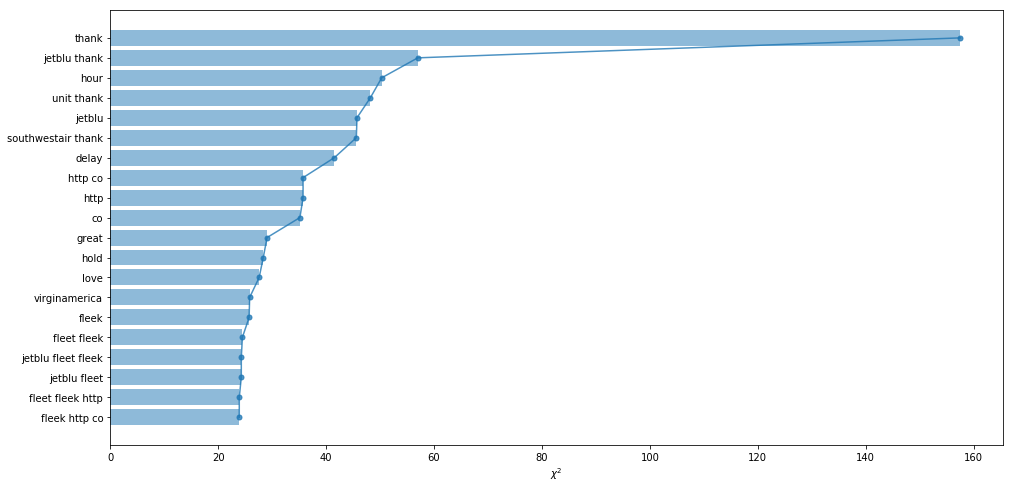

In [30]:
plt.figure(figsize=(16,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

In [31]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
max_fatures = 30000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(result['Reviews'].values)
X1 = tokenizer.texts_to_sequences(result['Reviews'].values)
X1 = pad_sequences(X1)

C:\Users\DELL\Anaconda3\lib\site-packages\keras_preprocessing\text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [34]:
Y1 = pd.get_dummies(result['Positivity']).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

(7500, 23) (7500, 2)
(2500, 23) (2500, 2)


In [35]:
embed_dim = 150
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X1.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 150)           4500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               280800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 4,781,202
Trainable params: 4,781,202
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
batch_size = 32
model.fit(X1_train, Y1_train, nb_epoch = 10, batch_size=batch_size, verbose = 2)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/10
 - 31s - loss: 0.4806 - acc: 0.7657
Epoch 2/10
 - 30s - loss: 0.3070 - acc: 0.8737
Epoch 3/10
 - 30s - loss: 0.2149 - acc: 0.9131
Epoch 4/10
 - 30s - loss: 0.1562 - acc: 0.9360
Epoch 5/10
 - 30s - loss: 0.1190 - acc: 0.9549
Epoch 6/10
 - 29s - loss: 0.0933 - acc: 0.9664
Epoch 7/10
 - 29s - loss: 0.0764 - acc: 0.9703
Epoch 8/10
 - 30s - loss: 0.0672 - acc: 0.9760
Epoch 9/10
 - 30s - loss: 0.0487 - acc: 0.9807
Epoch 10/10
 - 29s - loss: 0.0397 - acc: 0.9851


In [37]:
score,acc = model.evaluate(X1_test, Y1_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 1.19
acc: 0.77


In [38]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X1_test)):
    
    result = model.predict(X1_test[x].reshape(1,X1_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y1_test[x]):
        if np.argmax(Y1_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y1_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 77.27272727272727 %
neg_acc 77.01227830832197 %
